## XGBoost algorithm for MNIST dataset classification (Part 2/2)

### package imports, data loading

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import time

#solve kernel problems during XGBoost training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from matplotlib import colors
digit_colors = ["red","yellow","black","blue","plum","magenta","aqua","lime","orange","olive"]

In [77]:
#load data that was prepared in Part 1/2
data_direcory = "data"
y_train = pd.read_csv(data_direcory + "/y_train.csv", header=None)
y_test = pd.read_csv(data_direcory + "/y_test.csv", header=None)
y_train.columns = ['label']
y_test.columns = ['label']

x_train_pca = pd.read_csv(data_direcory + "/x_train_pca_final.csv", header=None)
x_test_pca = pd.read_csv(data_direcory + "/x_test_pca_final.csv", header=None)


### XGBoost parameter description

#### General Parameters
Overall functionality of XGBoost.
1. booster [default=gbtree]
Select the type of model to run at each iteration. It has 2 options:
gbtree: tree-based models
gblinear: linear models
2. silent [default=0]:
Silent mode is activated is set to 1, i.e. no running messages will be printed.
It’s generally good to keep it 0 as the messages might help in understanding the model.
3. nthread [default to maximum number of threads available if not set]
This is used for parallel processing and number of cores in the system should be entered
If you wish to run on all cores, value should not be entered and algorithm will detect automatically
There are 2 more parameters which are set automatically by XGBoost and you need not worry about them. Lets move on to Booster parameters.

#### Booster Parameters
Consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

1. eta [default=0.3]  
Analogous to learning rate in GBM. 
Makes the model more robust by shrinking the weights on each step.  
Typical final values to be used: 0.01-0.2
2. min_child_weight [default=1]  
Defines the minimum sum of weights of all observations required in a child.
This is similar to min_child_leaf in GBM but not exactly. This refers to min “sum of weights” of observations while GBM has min “number of observations”.
Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.  
Too high values can lead to under-fitting hence, it should be tuned using CV.
3. max_depth [default=6]  
The maximum depth of a tree, same as GBM.
Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
Should be tuned using CV.  
Typical values: 3-10
4. max_leaf_nodes  
The maximum number of terminal nodes or leaves in a tree.
Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.  
If this is defined, GBM will ignore max_depth.
5. gamma [default=0]  
A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
6. max_delta_step [default=0]  
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.
7. subsample [default=1]  
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.  
Typical values: 0.5-1
8. colsample_bytree [default=1]  
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.  
Typical values: 0.5-1
9. colsample_bylevel [default=1]  
Denotes the subsample ratio of columns for each split, in each level.
I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
10. lambda [default=1]  
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
11. alpha [default=0]  
L1 regularization term on weight (analogous to Lasso regression).
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
scale_pos_weight [default=1]    
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.

#### Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.

1. objective [default=reg:linear]  
This defines the loss function to be minimized. Mostly used values are:
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
2. eval_metric [ default according to objective ]  
The metric to be used for validation data.
The default values are rmse for regression and error for classification.
Typical values are:
rmse – root mean square error
mae – mean absolute error
logloss – negative log-likelihood
error – Binary classification error rate (0.5 threshold)
merror – Multiclass classification error rate
mlogloss – Multiclass logloss
auc: Area under the curve
3. seed [default=0]  
The random number seed.  
Can be used for generating reproducible results and also for parameter tuning.  

XGBoost vs. Sklearn naming convention (xgboost –> sklearn): 
- eta –> learning_rate
- lambda –> reg_lambda
- alpha –> reg_alpha

In [11]:
#classification (PCA data)
start = time.time()
print("Training set shape: {}".format(x_train_pca.shape))
model = XGBClassifier()
model.fit(x_train_pca, y_train)
end = time.time()
print("Training duration: {:.2f} s".format(end - start))

#testing
y_pred = model.predict(x_test_pca)
predictions = [round(value) for value in y_pred]
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100.0))

Training set shape: (60000, 40)
Training duration: 270.93 s
Accuracy: 91.11%


Training of XGBoost for the whole reduced dataset (matrix 60000 x 40) takes more than 4 minutes. For the purpose of cross-validation tuning of parameters, only a subset will be used (variable `SUBSET_SIZE`). Labels of reduced dataset will be equally distributed based on size of the subset.

In [78]:
# Use only subset samples for each label
SUBSET_SIZE = 1200
np.random.seed(123)
selected_indeces = []
for label in np.unique(y_train):
    label_indices = np.where(y_train == label)[0]
    subsample_label = np.random.choice(label_indices,size=SUBSET_SIZE)
    selected_indeces.extend(subsample_label)
print("Number of training samples: {}".format(len(selected_indeces)))
print("Only unique values are present: {}".format(len(np.unique(subsample_label)) != len(subsample_label)))

Number of training samples: 12000
Only unique values are present: True


In [79]:
import tensorflow as tf

#load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train / 255.0).reshape([60000, 28*28])
x_test = (x_test / 255.0).reshape([10000, 28*28])
reduced_x_train = x_train[selected_indeces]
reduced_y_train = y_train[selected_indeces]

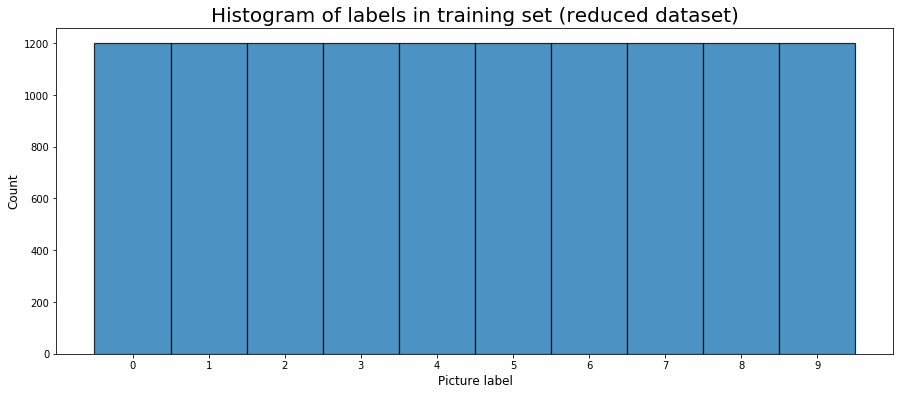

In [80]:
plt.figure(figsize=(15,6))
bins = np.arange(11) - 0.5 #to center xticks
plt.hist(reduced_y_train, edgecolor='black', linewidth=1.2, bins=bins, alpha=0.8)
plt.title("Histogram of labels in training set (reduced dataset)", fontsize=20)
plt.xlabel("Picture label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(0,10))
plt.show()

### Model tuning, Cross-validation grid search

In [81]:
x_train_pca_reduced = x_train_pca.iloc[selected_indeces,:]
y_train_pca_reduced = y_train[selected_indeces]

print("Training set size:\t{}".format(x_train_pca_reduced.shape))
print("Labels set size:\t{}".format(y_train_pca_reduced.shape))

Training set size:	(12000, 40)
Labels set size:	(12000,)


In [38]:
#classification (PCA data)
start = time.time()
xgb_model = XGBClassifier()

test_params = {
    'eta':[0.01,0.1,0.2],
    'min_child_weight':[4,5,6],
    'max_depth':[4,5,6],
    'gamma':[0.0,0.2,0.4]
}

model = GridSearchCV(estimator = xgb_model,param_grid = test_params,cv=5)
model.fit(x_train_pca_reduced,y_train_pca_reduced)
end = time.time()
print("Training set shape: {}".format(x_train_pca_reduced.shape))
print("Training duration: {}".format(time.strftime('%Hh:%Mm:%Ss', time.gmtime(end - start))))
print("Best parameters: {}".format(model.best_params_))
print("Best score: {:.4f}".format(model.best_score_))

#testing
y_pred = model.predict(x_test_pca)
predictions = [round(value) for value in y_pred]
accuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100.0))

Training set shape: (12000, 40)
Training duration: 06h:13m:32s
Best parameters: {'eta': 0.01, 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 4}
Best score: 0.9380
Accuracy: 93.40%


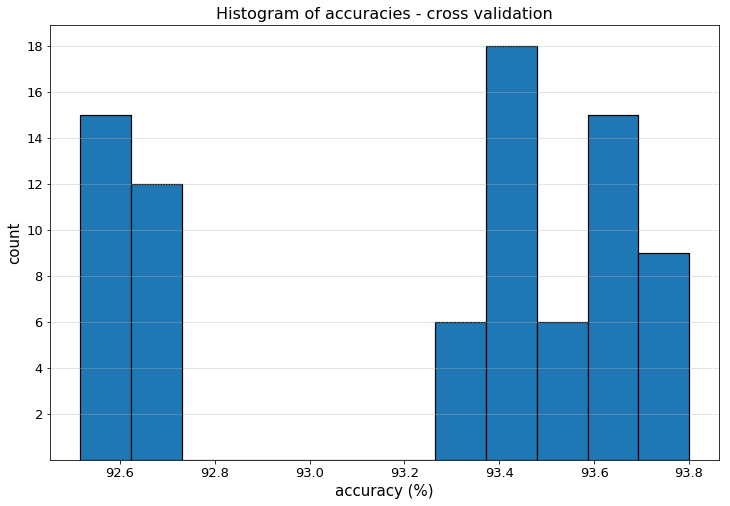

In [71]:
cv_results = pd.DataFrame(model.cv_results_)
fig = plt.figure(figsize=(12,8))
plt.hist(cv_results.mean_test_score*100, edgecolor='black', linewidth=1.2, bins=12)
plt.title("Histogram of accuracies - cross validation",fontsize=16)
plt.xlabel("accuracy (%)", fontsize=15)
plt.ylabel("count", fontsize=15)
plt.yticks(range(2,20,2), fontsize=13)
plt.xticks(fontsize=13)
plt.grid(axis='y',linestyle='--', linewidth=0.5)


### Comparison of cross validation for different training set sizes for PCA dataset

<table style="font-size:110%;width:100%">
  <tr>
    <th>Training set shape</th>
    <th>Training duration</th>
    <th>Best parameters</th>
    <th>Accuracy</th>
  </tr>
  <tr>
    <td>(3000, 40)</td>
    <td>00h:38m:44s</td>
    <td>{'eta': 0.01, 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 4}</td>
    <td>90.67%</td>  
  </tr>
  <tr>
    <td>(12000, 40)</td>
    <td>06h:21m:47s</td>
    <td>{'eta': 0.01, 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 4}</td>
    <td>93.40%</td>  
  </tr>
</table>

### Saving the cross validation results

In [14]:
import pickle
with open('best_xgboost_model.pkl', 'wb') as fid:
    pickle.dump(model, fid)
    
#to load
# with open('best_xgboost_model.pkl', 'rb') as fid:
#     gnb = pickle.load(fid)

### Final model training

The results from cross validation (in total 405 fits) show that parameter tuning did not vastly improve the model's accuracy, which is roughly between 92.5% - 94%. As the final step for this analysis, the best parameters will be used to fit the whole reduced dataset by PCA - training set shape (60000, 40).

In [93]:
start = time.time()
xgb_model_final = XGBClassifier()
final_params = {'eta': 0.01, 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 4}
xgb_model_final.set_params(**final_params)
xgb_model_final.fit(x_train_pca, y_train)
end = time.time()
print("Training duration: {:.2f} s".format(end - start))

predict_and_print_accuracy(xgb_model_final, x_train_pca, y_train, "Training accuracy")
predict_and_print_accuracy(xgb_model_final, x_test_pca, y_test, "Testing accuracy")

Training duration: 471.37 s
Training accuracy: 98.69%
Testing accuracy: 95.08%


In [92]:
def predict_and_print_accuracy(model, X, Y, accuracy_info="Accuracy"):
    y_pred = model.predict(X)
    predictions = [round(value) for value in y_pred]
    accuracy = metrics.accuracy_score(Y, predictions)
    print("{}: {:.2f}%".format(accuracy_info, accuracy * 100.0))